In [1]:
import pandas as pd
import numpy as np
import re
import commons as cmns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Audio
sound_file = 'beep.wav'

In [2]:
data=pd.read_csv('all_BTC_Data.csv',sep=',')

In [3]:
data.shape

(2436, 738)

In [4]:

hashrate_cols = [col for col in data.columns if 'hashrate' in col]
data.drop(columns=hashrate_cols, inplace=True)
#for col in hashrate_cols:
#    data[col] = np.log(data[col] + 1) 
'''
difficulty_cols = [col for col in data.columns if 'difficulty' in col]
for col in difficulty_cols:
    data[col] = np.log(data[col] + 1) 
var_cols = [col for col in data.columns if 'sentinused'and'var' in col]
for col in var_cols:
    data[col] = np.log(data[col] + 1) '''

"\ndifficulty_cols = [col for col in data.columns if 'difficulty' in col]\nfor col in difficulty_cols:\n    data[col] = np.log(data[col] + 1) \nvar_cols = [col for col in data.columns if 'sentinused'and'var' in col]\nfor col in var_cols:\n    data[col] = np.log(data[col] + 1) "

In [5]:
data.interpolate(axis=0,inplace=True)

C:\Users\13275\AppData\Local\Temp\ipykernel_8532\879274293.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(axis=0,inplace=True)


In [6]:
interval1 = (data['Date'] >= '2020/01/01') & (data['Date'] <= '2023/01/01')
interval2=(data['Date'] >= '2017/08/01') & (data['Date'] <= '2022/04/01')
interval3=(data['Date'] >= '2022/08/01') & (data['Date'] <= '2024/04/01')

In [7]:
data['one']=data['priceUSD'].shift(-1,fill_value=1)
seven=data['priceUSD'].shift(-7,fill_value=1)
fourteen=data['priceUSD'].shift(-14,fill_value=1)
thirty=data['priceUSD'].shift(-30,fill_value=1)
sixty=data['priceUSD'].shift(-60,fill_value=1)
ninety=data['priceUSD'].shift(-90,fill_value=1)

In [8]:
# Assuming 'data' is your DataFrame and it has a 'priceUSD' column with the daily closing prices of Bitcoin

# Calculate daily returns
data['daily_return'] = np.log(data['priceUSD'] / data['priceUSD'].shift(1))

# Calculate the daily standard deviation (volatility) of the returns
# Note: This will result in a NaN for the first row, because the previous price is not known
daily_volatility = data['daily_return'].std()

# Create a new column for the rolling daily volatility, using a 30-day window
data['rolling_volatility_30d'] = data['daily_return'].rolling(window=30).std()

# To annualize the daily volatility, assuming 365 trading days for Bitcoin:
annualized_volatility = daily_volatility * np.sqrt(365)

# Add the annualized volatility as a new column
data['annualized_volatility'] = annualized_volatility

# The 'annualized_volatility' column will have the same value throughout since we calculated it using the global standard deviation
# If you want to observe how 30-day annualized volatility changes over time:
data['annualized_rolling_volatility_30d'] = data['rolling_volatility_30d'] * np.sqrt(365)

# Display the DataFrame with the new volatility columns
print(data[['priceUSD', 'daily_return', 'rolling_volatility_30d', 'annualized_volatility', 'annualized_rolling_volatility_30d']].tail())

      priceUSD  daily_return  rolling_volatility_30d  annualized_volatility  \
2431     70379      0.008261                0.025500               0.595143   
2432     70055     -0.004614                0.024386               0.595143   
2433     69970     -0.001214                0.023070               0.595143   
2434     70429      0.006539                0.023027               0.595143   
2435     69724     -0.010061                0.023174               0.595143   

      annualized_rolling_volatility_30d  
2431                           0.487176  
2432                           0.465884  
2433                           0.440758  
2434                           0.439925  
2435                           0.442744  


In [9]:
data['volatility_one']=data['rolling_volatility_30d'].shift(-1,fill_value=1)

In [10]:
interval1

0       False
1       False
2       False
3       False
4       False
        ...  
2431    False
2432    False
2433    False
2434    False
2435    False
Name: Date, Length: 2436, dtype: bool

In [11]:
df=data.loc[interval1]

In [12]:
#df['priceUSD']=one.loc[interval3]

In [13]:
df

,Unnamed: 0,Date,priceUSD,transactions,size,sentbyaddress,difficulty,mining_profitability,sentinusdUSD,transactionfeesUSD,...,price7rocUSD,price14rocUSD,price30rocUSD,price90rocUSD,one,daily_return,rolling_volatility_30d,annualized_volatility,annualized_rolling_volatility_30d,volatility_one
883,883,2020/01/01,7238,251561,441636,292748,13031658000899,0.1540,2022006877,0.287,...,-0.621,6.448,-1.060,-12.325,7127,-0.007570,0.016628,0.595143,0.317683,0.016854
884,884,2020/01/02,7127,295426,696127,363285,13798783827516,0.1110,3495275949,0.332,...,-2.067,-0.704,-2.620,-12.800,7250,-0.015455,0.016854,0.595143,0.321986,0.017171
885,885,2020/01/03,7250,316348,629151,414656,13798783827516,0.1440,5664998633,0.376,...,-0.178,0.537,-0.878,-10.811,7390,0.017111,0.017171,0.595143,0.328052,0.017511
886,886,2020/01/04,7390,287047,539139,364305,13798783827516,0.1430,3470997480,0.317,...,0.388,2.520,0.528,-7.813,7503,0.019126,0.017511,0.595143,0.334549,0.017606
887,887,2020/01/05,7503,287616,555135,346762,13798783827516,0.1310,2540098659,0.310,...,0.460,3.131,0.905,-7.003,7588,0.015175,0.017606,0.595143,0.336356,0.017481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,1975,2022/12/28,16640,272781,542347,529941,35364065900457,0.0704,5572254030,1.261,...,-1.132,-6.904,2.625,-14.220,16591,-0.009986,0.012768,0.595143,0.243930,0.012603
1976,1976,2022/12/29,16591,265814,692913,540607,35364065900457,0.0545,6313826970,1.285,...,-1.117,-5.644,1.084,-15.033,16550,-0.002949,0.012603,0.595143,0.240773,0.011377
1977,1977,2022/12/30,16550,290857,725552,585013,35364065900457,0.0658,7554069544,1.240,...,-1.664,-3.219,-2.058,-14.375,16570,-0.002474,0.011377,0.595143,0.217352,0.011221
1978,1978,2022/12/31,16570,242169,573296,499947,35364065900457,0.0557,4493923166,0.833,...,-1.551,-0.769,-2.867,-13.835,16559,0.001208,0.011221,0.595143,0.214372,0.011185


In [14]:
'''
if 'one' in df.columns:
    # Create a new list of column names with 'one' as the third element
    # Grab the current list of columns
    cols = list(df.columns)
    # Remove 'one' from its current position
    cols.remove('one')
    # Insert 'one' at the second index (third position, since index starts at 0)
    cols.insert(2, 'one')
    # Reorder DataFrame according to the new list of columns
    df = df[cols]'''

"\nif 'one' in df.columns:\n    # Create a new list of column names with 'one' as the third element\n    # Grab the current list of columns\n    cols = list(df.columns)\n    # Remove 'one' from its current position\n    cols.remove('one')\n    # Insert 'one' at the second index (third position, since index starts at 0)\n    cols.insert(2, 'one')\n    # Reorder DataFrame according to the new list of columns\n    df = df[cols]"

In [15]:
from datetime import datetime

# Convert string to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Convert datetime to ordinal
df['Date'] = df['Date'].apply(lambda x: x.toordinal())

C:\Users\13275\AppData\Local\Temp\ipykernel_8532\1555926713.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\13275\AppData\Local\Temp\ipykernel_8532\1555926713.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(lambda x: x.toordinal())


In [16]:
'''
y_ORI=df.iloc[:,2:3]
y_ORI
'''

'\ny_ORI=df.iloc[:,2:3]\ny_ORI\n'

In [17]:

from sklearn.preprocessing import StandardScaler
# Check and replace Inf/NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.mean(), inplace=True)  # or use another imputation strategy
'''
# Scale the data (optional based on data distribution)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.astype(np.float64))
df = pd.DataFrame(df_scaled, columns=df.columns)
'''

C:\Users\13275\AppData\Local\Temp\ipykernel_8532\4181542008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\13275\AppData\Local\Temp\ipykernel_8532\4181542008.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)  # or use another imputation strategy


'\n# Scale the data (optional based on data distribution)\nscaler = StandardScaler()\ndf_scaled = scaler.fit_transform(df.astype(np.float64))\ndf = pd.DataFrame(df_scaled, columns=df.columns)\n'

In [18]:
X_raw=df.iloc[:,3:17]

In [19]:
X_raw

,transactions,size,sentbyaddress,difficulty,mining_profitability,sentinusdUSD,transactionfeesUSD,median_transaction_feeUSD,confirmationtime,transactionvalueUSD,mediantransactionvalueUSD,activeaddresses,top100cap,fee_to_rewardUSD
883,251561,441636,292748,13031658000899,0.1540,2022006877,0.287,0.0654,8.276,12757,120.996,444396,15.167,0.457
884,295426,696127,363285,13798783827516,0.1110,3495275949,0.332,0.0841,10.213,16735,215.464,569087,15.138,0.776
885,316348,629151,414656,13798783827516,0.1440,5664998633,0.376,0.1120,8.521,23302,211.058,619640,15.152,0.770
886,287047,539139,364305,13798783827516,0.1430,3470997480,0.317,0.0829,8.571,16928,156.720,540973,15.158,0.583
887,287616,555135,346762,13798783827516,0.1310,2540098659,0.310,0.0533,8.834,14695,150.613,515467,15.165,0.580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,272781,542347,529941,35364065900457,0.0704,5572254030,1.261,0.6060,8.571,53190,432.108,795623,14.715,1.932
1976,265814,692913,540607,35364065900457,0.0545,6313826970,1.285,0.5620,10.213,54195,456.917,833137,14.711,2.283
1977,290857,725552,585013,35364065900457,0.0658,7554069544,1.240,0.5190,9.114,50405,425.456,907447,14.690,2.161
1978,242169,573296,499947,35364065900457,0.0557,4493923166,0.833,0.3270,9.231,42790,402.231,745609,14.713,1.235


In [20]:
y = df['volatility_one']

In [21]:
#df['one'].remove

In [22]:
#y=df.iloc[:,2:3]
y

883     0.016854
884     0.017171
885     0.017511
886     0.017606
887     0.017481
          ...   
1975    0.012603
1976    0.011377
1977    0.011221
1978    0.011185
1979    0.011296
Name: volatility_one, Length: 1097, dtype: float64

In [23]:
y=np.ravel(y)

In [24]:
y

array([0.01685353, 0.01717105, 0.01751107, ..., 0.01122075, 0.01118512,
       0.01129616])

In [25]:
features_list=[]
technical_indicators=['sma','ema','wma','trx','mom','std','var','rsi','roc']
periods=['3','7','14','30','90']
for i in technical_indicators:
    for j in periods:
        string=str(j)+str(i)
        X=df.filter(like=string,axis=1)
        X=SimpleImputer(missing_values=0,strategy='most_frequent').fit_transform(X)
        X=pd.DataFrame(X)
        X.columns=df.filter(like=string,axis=1).columns
        rf1=RandomForestRegressor(random_state=7,n_jobs=-1)
        rfecv=RFECV(rf1,step=0.9,min_features_to_select=1,verbose=1,cv=5,scoring='neg_mean_absolute_error', n_jobs=-1)
        rfecv.fit(X,y)
        if rfecv.n_features_>1:
            rf1.fit(X,y)
            maximp=rf1.feature_importances_.max()
            for x in range(len(rf1.feature_importances_)):
                if maximp==rf1.feature_importances_[x]:
                    new_features = X.columns[x]
        else:
            mask = rfecv.get_support()
            new_features = X.columns[mask]
        features_list.append(str(new_features))
        print(string+': '+new_features)


3sma: price3smaUSD
7sma: price7smaUSD
Fitting estimator with 15 features.
14sma: price14smaUSD
30sma: mining_profitability30sma
90sma: mining_profitability90sma
3ema: price3emaUSD
7ema: price7emaUSD
14ema: price14emaUSD
30ema: mining_profitability30ema
90ema: mining_profitability90ema
3wma: price3wmaUSD
7wma: price7wmaUSD
14wma: price14wmaUSD
30wma: price30wmaUSD
90wma: mining_profitability90wma
3trx: price3trxUSD
7trx: top100cap7trx
Fitting estimator with 15 features.
Fitting estimator with 2 features.
Index(['14trx: price14trxUSD'], dtype='object')
30trx: price30trxUSD
90trx: mediantransactionvalue90trxUSD
3mom: price3momUSD
7mom: price7momUSD
14mom: top100cap14mom
30mom: top100cap30mom
Fitting estimator with 15 features.
90mom: top100cap90mom
3std: price3stdUSD
7std: price7stdUSD
14std: mining_profitability14std
30std: mining_profitability30std
Fitting estimator with 15 features.
Fitting estimator with 2 features.
Index(['90std: mining_profitability90std'], dtype='object')
3var: pri

In [26]:
#Audio(data=data, rate=44100, autoplay=True)

In [27]:
l1=[]
for j in range(len(features_list)):
    result1 = re.search("'(.*)'],", features_list[j])
    if result1!=None:
        l1.append(result1.group(1))
for i in range(len(features_list)):
    result2 = re.search('.*',features_list[i])
    if len(result2.group(0))<33:
        l1.append(result2.group(0))

In [28]:
l1.sort()

In [29]:
l1

['difficulty14roc',
 'difficulty14rsi',
 'difficulty3rsi',
 'difficulty7rsi',
 'difficulty90rsi',
 'mediantransactionvalue90trxUSD',
 'mediantransactionvalue90varUSD',
 'mining_profitability14std',
 'mining_profitability30ema',
 'mining_profitability30sma',
 'mining_profitability30std',
 'mining_profitability90ema',
 'mining_profitability90sma',
 'mining_profitability90std',
 'mining_profitability90wma',
 'price14emaUSD',
 'price14smaUSD',
 'price14trxUSD',
 'price14varUSD',
 'price14wmaUSD',
 'price30trxUSD',
 'price30varUSD',
 'price30wmaUSD',
 'price3emaUSD',
 'price3momUSD',
 'price3rocUSD',
 'price3smaUSD',
 'price3stdUSD',
 'price3trxUSD',
 'price3varUSD',
 'price3wmaUSD',
 'price7emaUSD',
 'price7momUSD',
 'price7rocUSD',
 'price7smaUSD',
 'price7stdUSD',
 'price7varUSD',
 'price7wmaUSD',
 'price90rocUSD',
 'top100cap14mom',
 'top100cap30mom',
 'top100cap30roc',
 'top100cap30rsi',
 'top100cap7trx',
 'top100cap90mom']

In [30]:
'''
df_original = scaler.inverse_transform(df_scaled)
df_original = pd.DataFrame(df_original, columns=df.columns)

# Optionally, convert data type back to float32 if needed
df = df_original.astype(np.float32)

'''

'\ndf_original = scaler.inverse_transform(df_scaled)\ndf_original = pd.DataFrame(df_original, columns=df.columns)\n\n# Optionally, convert data type back to float32 if needed\ndf = df_original.astype(np.float32)\n\n'

In [31]:
df_reduced=df[l1]

In [32]:
df_reduced.head()

,difficulty14roc,difficulty14rsi,difficulty3rsi,difficulty7rsi,difficulty90rsi,mediantransactionvalue90trxUSD,mediantransactionvalue90varUSD,mining_profitability14std,mining_profitability30ema,mining_profitability30sma,...,price7stdUSD,price7varUSD,price7wmaUSD,price90rocUSD,top100cap14mom,top100cap30mom,top100cap30roc,top100cap30rsi,top100cap7trx,top100cap90mom
883,1.202,80.528,99.997,97.987,76.305,-0.072,4318,0.015,0.146,0.144,...,152.748,5833.0,7326,-12.325,-0.012,0.107,0.711,66.491,0.001,0.632
884,7.027,96.804,100.000,99.804,81.534,-0.074,4276,0.023,0.143,0.142,...,207.172,10730.0,7276,-12.800,-0.098,0.117,0.776,63.431,-0.003,0.609
885,6.566,96.804,100.000,99.804,81.534,-0.075,4126,0.023,0.143,0.142,...,208.882,10908.0,7262,-10.811,-0.094,0.083,0.549,64.259,-0.005,0.624
886,6.566,96.804,100.000,99.804,81.534,-0.077,4099,0.023,0.143,0.142,...,214.273,11478.0,7284,-7.813,-0.021,0.081,0.536,64.617,-0.006,0.631
887,6.566,96.804,100.000,99.804,81.534,-0.079,4178,0.023,0.142,0.142,...,229.843,13207.0,7333,-7.003,-0.016,0.106,0.707,64.996,-0.006,0.638


In [33]:
X=cmns.drop_high_vif(df_reduced,thresh=5)

dropping 'price7emaUSD' at index: 31
dropping 'price14emaUSD' at index: 15
dropping 'price3wmaUSD' at index: 29
dropping 'price7wmaUSD' at index: 34
dropping 'price14wmaUSD' at index: 18
dropping 'price3emaUSD' at index: 21
dropping 'price3smaUSD' at index: 23
dropping 'price14smaUSD' at index: 15
dropping 'mining_profitability30ema' at index: 8
dropping 'mining_profitability90wma' at index: 13
dropping 'mining_profitability90ema' at index: 10
dropping 'price30wmaUSD' at index: 16
dropping 'top100cap30roc' at index: 29
dropping 'difficulty7rsi' at index: 3
dropping 'mining_profitability30sma' at index: 7
dropping 'difficulty90rsi' at index: 3
dropping 'mining_profitability90sma' at index: 7
dropping 'price7stdUSD' at index: 20
dropping 'mining_profitability30std' at index: 6
dropping 'difficulty14rsi' at index: 1
dropping 'mining_profitability90std' at index: 5
dropping 'price3stdUSD' at index: 11
dropping 'price7rocUSD' at index: 14
dropping 'price7smaUSD' at index: 14
dropping 'top10

In [34]:
X.shape

(1097, 15)

In [35]:
cmns.vif_values(X)

difficulty14roc                   1.367508
mediantransactionvalue90trxUSD    1.664617
price14trxUSD                     3.181199
price14varUSD                     3.512223
price30trxUSD                     4.014405
price30varUSD                     2.304654
price3momUSD                      2.342765
price3trxUSD                      3.883772
price3varUSD                      1.844656
price7momUSD                      3.630744
price7varUSD                      3.402332
top100cap14mom                    2.247272
top100cap30mom                    3.378327
top100cap30rsi                    1.988632
top100cap90mom                    2.369727
dtype: float64

In [36]:
Raw=cmns.drop_high_vif(X_raw,thresh=10)

dropping 'median_transaction_feeUSD' at index: 7
dropping 'difficulty' at index: 3
dropping 'sentbyaddress' at index: 2
dropping 'top100cap' at index: 9
dropping 'size' at index: 1
dropping 'activeaddresses' at index: 7
dropping 'mediantransactionvalueUSD' at index: 6
dropping 'transactions' at index: 0
Remaining variables:
Index(['mining_profitability', 'sentinusdUSD', 'transactionfeesUSD',
       'confirmationtime', 'transactionvalueUSD', 'fee_to_rewardUSD'],
      dtype='object')


In [37]:
#cmns.vif_values(X_raw)
cmns.vif_values(Raw)

mining_profitability    9.242546
sentinusdUSD            3.788438
transactionfeesUSD      5.457004
confirmationtime        6.871139
transactionvalueUSD     6.409309
fee_to_rewardUSD        5.698653
dtype: float64

In [38]:
Raw['Date']=df['Date']

C:\Users\13275\AppData\Local\Temp\ipykernel_8532\415555305.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Raw['Date']=df['Date']


In [39]:
X['Date']=df['Date']

C:\Users\13275\AppData\Local\Temp\ipykernel_8532\3012381705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date']=df['Date']


In [40]:
X

,difficulty14roc,mediantransactionvalue90trxUSD,price14trxUSD,price14varUSD,price30trxUSD,price30varUSD,price3momUSD,price3trxUSD,price3varUSD,price7momUSD,price7varUSD,top100cap14mom,top100cap30mom,top100cap30rsi,top100cap90mom,Date
883,1.202,-0.072,-0.111,9515,-0.314,28623,-231.566,-0.206,3878.000,-45.241,5833.0,-0.012,0.107,66.491,0.632,737425
884,7.027,-0.074,-0.102,10638,-0.309,29355,-261.045,-0.495,4729.000,-150.435,10730.0,-0.098,0.117,63.431,0.609,737426
885,6.566,-0.075,-0.093,10214,-0.303,29328,-42.402,-0.374,3051.000,-12.963,10908.0,-0.094,0.083,64.259,0.624,737427
886,6.566,-0.077,-0.082,9791,-0.296,29574,152.469,0.025,11526.000,28.544,11478.0,-0.021,0.081,64.617,0.631,737428
887,6.566,-0.079,-0.065,11727,-0.289,30437,376.272,0.452,10731.000,34.381,13207.0,-0.016,0.106,64.996,0.638,737429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,3.270,-0.100,-0.060,51641,-0.212,82135,-179.890,-0.138,8243.000,-190.493,4384.0,-0.155,-0.505,28.366,-1.073,738517
1976,3.270,-0.100,-0.066,13660,-0.207,76543,-258.919,-0.242,8530.000,-187.492,9487.0,-0.178,-0.507,28.225,-1.019,738518
1977,3.270,-0.099,-0.073,8905,-0.203,82274,-257.127,-0.291,1350.000,-280.082,14059.0,-0.127,-0.529,27.482,-1.002,738519
1978,3.270,-0.099,-0.080,10853,-0.200,86919,-69.693,-0.257,287.999,-261.088,14638.0,-0.039,-0.480,29.601,-0.941,738520


In [41]:
df_merged=Raw.merge(X.drop_duplicates(subset='Date'),how='left')

In [42]:
df_merged.shape

(1097, 22)

In [43]:
df_merged.drop(columns='Date',inplace=True)

In [44]:
#df_merged['priceUSD']=np.ravel(y)

In [45]:
X=cmns.drop_high_vif(df_merged,thresh=10)

dropping 'top100cap30rsi' at index: 19
dropping 'mining_profitability' at index: 0
Remaining variables:
Index(['sentinusdUSD', 'transactionfeesUSD', 'confirmationtime',
       'transactionvalueUSD', 'fee_to_rewardUSD', 'difficulty14roc',
       'mediantransactionvalue90trxUSD', 'price14trxUSD', 'price14varUSD',
       'price30trxUSD', 'price30varUSD', 'price3momUSD', 'price3trxUSD',
       'price3varUSD', 'price7momUSD', 'price7varUSD', 'top100cap14mom',
       'top100cap30mom', 'top100cap90mom'],
      dtype='object')


In [46]:
X.shape

(1097, 19)

In [47]:
cmns.vif_values(X)

sentinusdUSD                      3.695863
transactionfeesUSD                6.722559
confirmationtime                  5.132940
transactionvalueUSD               5.610161
fee_to_rewardUSD                  8.964671
difficulty14roc                   1.398768
mediantransactionvalue90trxUSD    3.704016
price14trxUSD                     3.282277
price14varUSD                     3.616319
price30trxUSD                     4.722445
price30varUSD                     2.350909
price3momUSD                      2.348431
price3trxUSD                      3.932110
price3varUSD                      1.882027
price7momUSD                      3.693441
price7varUSD                      3.638578
top100cap14mom                    2.272877
top100cap30mom                    3.456269
top100cap90mom                    2.976099
dtype: float64

In [48]:
if 'priceUSD' in X.columns:
    X.drop(columns='priceUSD',inplace=True)

In [49]:
rf_final=RandomForestRegressor(random_state=7,n_jobs=-1)

In [50]:
rf_final.fit(X,y)

RandomForestRegressor(n_jobs=-1, random_state=7)

In [51]:
imp_feat=cmns.feature_importance(X.columns,rf_final.feature_importances_)

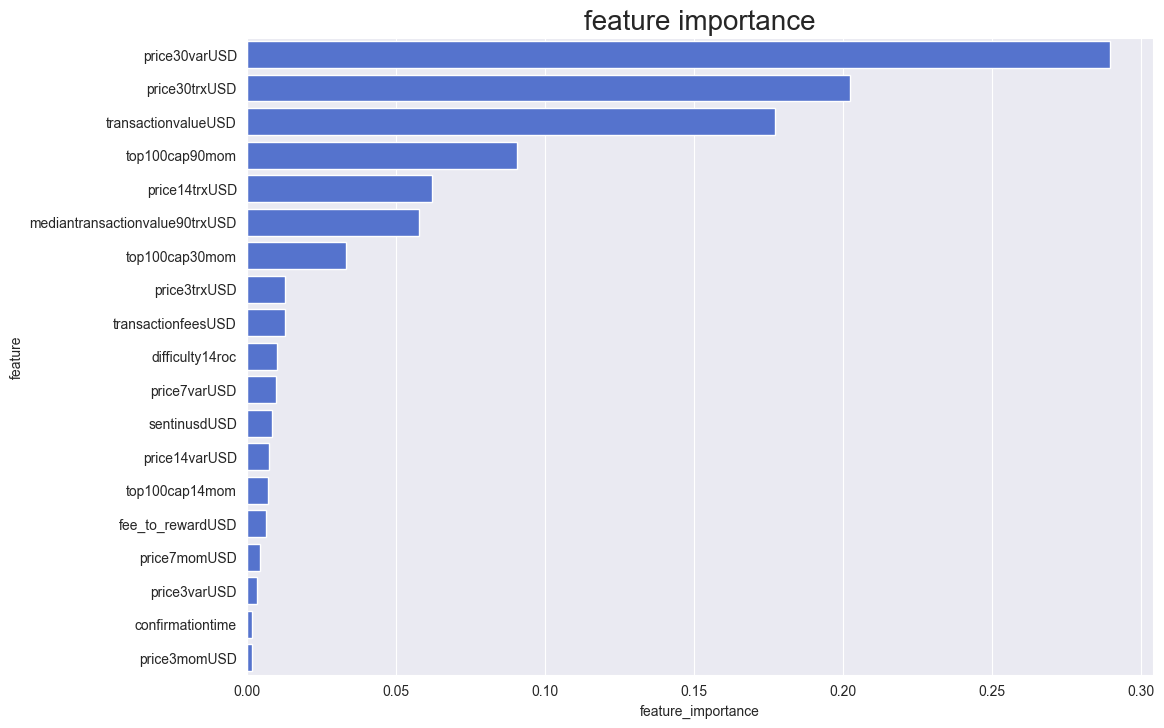

In [52]:
cmns.plot_feature_importance(imp_feat,'feature importance')

In [53]:
imp_feat[imp_feat['feature_importance']>0]


,feature,feature_importance
0,price30varUSD,0.289639
1,price30trxUSD,0.202391
2,transactionvalueUSD,0.177160
3,top100cap90mom,0.090608
4,price14trxUSD,0.062165
5,mediantransactionvalue90trxUSD,0.057913
6,top100cap30mom,0.033395
7,price3trxUSD,0.012983
8,transactionfeesUSD,0.012697
9,difficulty14roc,0.010269


In [54]:
cols=[0,1,2,3,4,5,6,7,9,11,16,18,16,20]

In [55]:
#selected=imp_feat[imp_feat['feature_importance']>0.001]
selected=imp_feat.filter(cols,axis=0)

In [56]:
selected

,feature,feature_importance
0,price30varUSD,0.289639
1,price30trxUSD,0.202391
2,transactionvalueUSD,0.177160
3,top100cap90mom,0.090608
4,price14trxUSD,0.062165
5,mediantransactionvalue90trxUSD,0.057913
6,top100cap30mom,0.033395
7,price3trxUSD,0.012983
9,difficulty14roc,0.010269
11,sentinusdUSD,0.008566


In [57]:
selected.feature_importance.sum()

0.9501770558911278

In [58]:
X_high=X[selected.feature]

In [59]:
X_high.shape

(1097, 12)

In [60]:
X_high.sort_index(axis=1,inplace=True)

C:\Users\13275\AppData\Local\Temp\ipykernel_8532\554794614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_high.sort_index(axis=1,inplace=True)


In [198]:
X_high

,difficulty3rsi,fee_to_rewardUSD,mediantransactionvalue30trxUSD,mediantransactionvalue3rocUSD,mining_profitability90trx,price14momUSD,price30varUSD,price3momUSD,price90momUSD,price90varUSD,sentinusdUSD,top100cap90roc,transactionvalueUSD
0,99.997,0.457,-0.240,-25.004,-0.307,438.400,28623,-231.566,-1017.000,573722,2022006877,4.345,12757
1,100.000,0.776,-0.261,-3.650,-0.308,-50.548,29355,-261.045,-1046.000,581575,3495275949,4.194,16735
2,100.000,0.770,-0.279,-3.731,-0.310,38.717,29328,-42.402,-878.841,587195,5664998633,4.295,23302
3,100.000,0.583,-0.300,29.525,-0.311,181.633,29574,152.469,-626.347,590895,3470997480,4.344,16928
4,100.000,0.580,-0.325,-30.098,-0.312,227.791,30437,376.272,-565.003,593111,2540098659,4.395,14695
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,99.043,1.932,-0.085,25.169,-0.406,-1234.000,82135,-179.890,-2758.000,2474152,5572254030,-6.794,53190
1093,99.043,2.283,-0.087,12.176,-0.405,-992.473,76543,-258.919,-2936.000,2479394,6313826970,-6.481,54195
1094,99.043,2.161,-0.090,-8.328,-0.404,-550.542,82274,-257.127,-2778.000,2489811,7554069544,-6.385,50405
1095,99.043,1.235,-0.094,-6.914,-0.403,-128.481,86919,-69.693,-2661.000,2500289,4493923166,-6.009,42790


In [65]:
X_high['volatility']=np.ravel(y)
price = df['priceUSD']
price = np.ravel(price)
X_high['priceUSD'] = np.ravel(price)

C:\Users\13275\AppData\Local\Temp\ipykernel_8532\34886841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_high['volatility']=np.ravel(y)
C:\Users\13275\AppData\Local\Temp\ipykernel_8532\34886841.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_high['priceUSD'] = np.ravel(price)


In [66]:
X_high

,difficulty14roc,mediantransactionvalue90trxUSD,price14trxUSD,price30trxUSD,price30varUSD,price3momUSD,price3trxUSD,price3varUSD,sentinusdUSD,top100cap30mom,top100cap90mom,transactionvalueUSD,volatility,priceUSD
0,1.202,-0.072,-0.111,-0.314,28623,-231.566,-0.206,3878.000,2022006877,0.107,0.632,12757,0.016854,7238
1,7.027,-0.074,-0.102,-0.309,29355,-261.045,-0.495,4729.000,3495275949,0.117,0.609,16735,0.017171,7127
2,6.566,-0.075,-0.093,-0.303,29328,-42.402,-0.374,3051.000,5664998633,0.083,0.624,23302,0.017511,7250
3,6.566,-0.077,-0.082,-0.296,29574,152.469,0.025,11526.000,3470997480,0.081,0.631,16928,0.017606,7390
4,6.566,-0.079,-0.065,-0.289,30437,376.272,0.452,10731.000,2540098659,0.106,0.638,14695,0.017481,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,3.270,-0.100,-0.060,-0.212,82135,-179.890,-0.138,8243.000,5572254030,-0.505,-1.073,53190,0.012603,16640
1093,3.270,-0.100,-0.066,-0.207,76543,-258.919,-0.242,8530.000,6313826970,-0.507,-1.019,54195,0.011377,16591
1094,3.270,-0.099,-0.073,-0.203,82274,-257.127,-0.291,1350.000,7554069544,-0.529,-1.002,50405,0.011221,16550
1095,3.270,-0.099,-0.080,-0.200,86919,-69.693,-0.257,287.999,4493923166,-0.480,-0.941,42790,0.011185,16570


<Axes: >

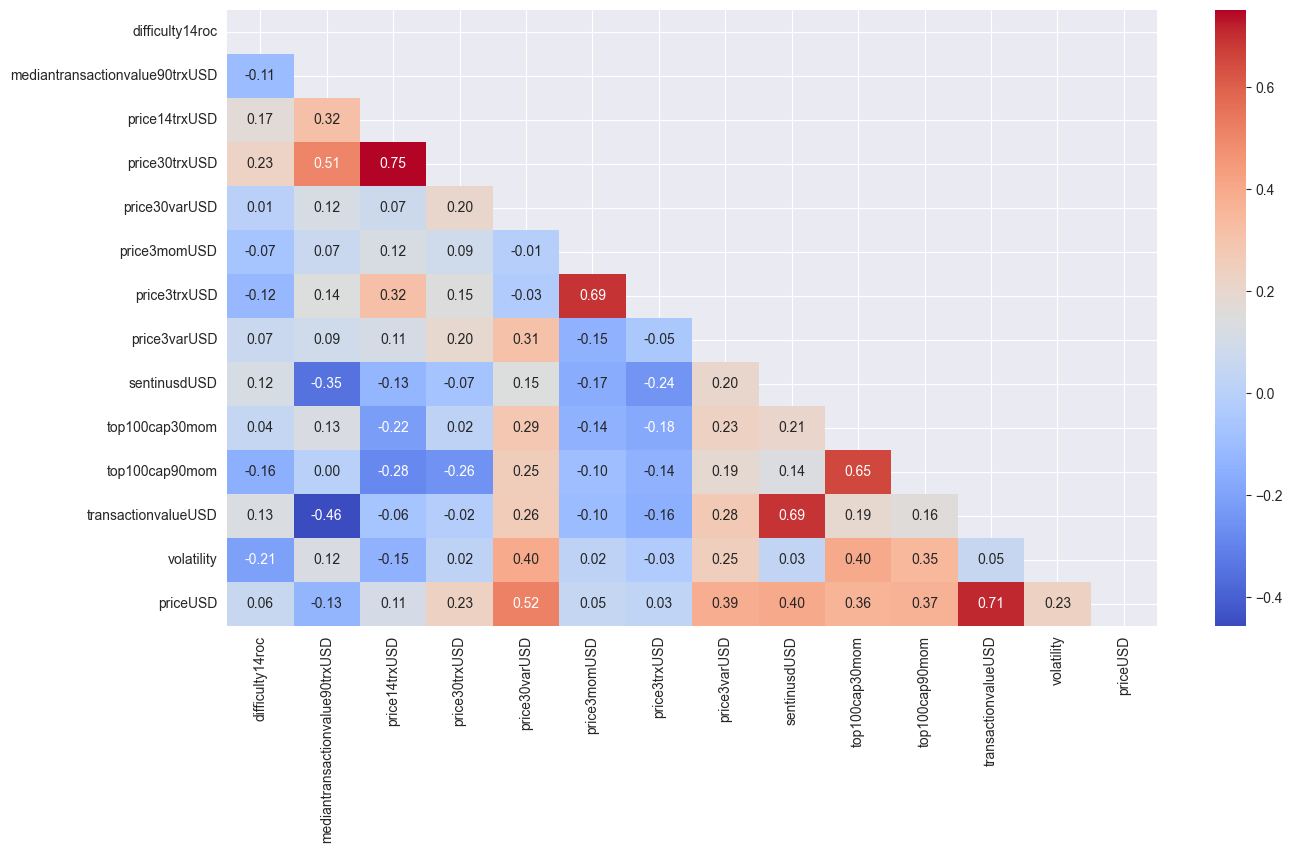

In [67]:
corr = X_high.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

In [69]:
X_high=X_high[X_high['volatility']!=1]

In [70]:
X_high = X_high.astype(np.float32)

In [71]:
X_high

,difficulty14roc,mediantransactionvalue90trxUSD,price14trxUSD,price30trxUSD,price30varUSD,price3momUSD,price3trxUSD,price3varUSD,sentinusdUSD,top100cap30mom,top100cap90mom,transactionvalueUSD,volatility,priceUSD
0,1.202,-0.072,-0.111,-0.314,28623.0,-231.565994,-0.206,3878.000000,2.022007e+09,0.107,0.632,12757.0,0.016854,7238.0
1,7.027,-0.074,-0.102,-0.309,29355.0,-261.045013,-0.495,4729.000000,3.495276e+09,0.117,0.609,16735.0,0.017171,7127.0
2,6.566,-0.075,-0.093,-0.303,29328.0,-42.402000,-0.374,3051.000000,5.664998e+09,0.083,0.624,23302.0,0.017511,7250.0
3,6.566,-0.077,-0.082,-0.296,29574.0,152.468994,0.025,11526.000000,3.470998e+09,0.081,0.631,16928.0,0.017606,7390.0
4,6.566,-0.079,-0.065,-0.289,30437.0,376.272003,0.452,10731.000000,2.540099e+09,0.106,0.638,14695.0,0.017481,7503.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,3.270,-0.100,-0.060,-0.212,82135.0,-179.889999,-0.138,8243.000000,5.572254e+09,-0.505,-1.073,53190.0,0.012603,16640.0
1093,3.270,-0.100,-0.066,-0.207,76543.0,-258.919006,-0.242,8530.000000,6.313827e+09,-0.507,-1.019,54195.0,0.011377,16591.0
1094,3.270,-0.099,-0.073,-0.203,82274.0,-257.127014,-0.291,1350.000000,7.554070e+09,-0.529,-1.002,50405.0,0.011221,16550.0
1095,3.270,-0.099,-0.080,-0.200,86919.0,-69.693001,-0.257,287.998993,4.493923e+09,-0.480,-0.941,42790.0,0.011185,16570.0


In [72]:
X_high.to_csv('data/reg_interval20-23ndvola.csv',sep=',',index=False)

In [73]:
from sklearn.ensemble import IsolationForest
outlier=IsolationForest(contamination=0.9)
price=X_high['priceUSD']
price=price.values
price=np.reshape(price,(-1,1))
outlier = IsolationForest(contamination='auto')
outlier.fit(price)
outs=outlier.predict(price)
X_high['outlier']=pd.DataFrame(zip(outs))
X_high=X_high.query('outlier != -1')
X_high.reset_index(drop=True,inplace=True)
X_high.drop(columns=['outlier'],inplace=True)

C:\Users\13275\AppData\Local\Temp\ipykernel_8532\2175034391.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_high.drop(columns=['outlier'],inplace=True)


In [74]:
X_high.to_csv('data/reg_interval18-23volab1.csv',sep=',',index=False)

In [183]:
X_high.columns

Index(['difficulty3rsi', 'mining_profitability90trx', 'price14momUSD',
       'price30varUSD', 'price3momUSD', 'price3varUSD', 'price7momUSD',
       'price90momUSD', 'price90varUSD', 'sentinusdUSD', 'transactionvalueUSD',
       'priceUSD'],
      dtype='object')

In [184]:
X_high.shape

(638, 12)

In [185]:
'''df1=pd.read_csv('reg_interval1.csv',sep=',')
date_range = pd.date_range(start='2018-01-01', end='2021-01-01', freq='D')
'''


"df1=pd.read_csv('reg_interval1.csv',sep=',')\ndate_range = pd.date_range(start='2018-01-01', end='2021-01-01', freq='D')\n"

In [186]:
'''# Check if the date range length matches the number of rows in the DataFrame
if len(date_range) == len(df1):
    df1['Date'] = date_range
else:
    print("The date range does not match the number of rows in the DataFrame.")
df1.to_csv('reg_interval2.csv',sep=',',index=False)
# Show the updated DataFrame
print(df1.head())'''

'# Check if the date range length matches the number of rows in the DataFrame\nif len(date_range) == len(df1):\n    df1[\'Date\'] = date_range\nelse:\n    print("The date range does not match the number of rows in the DataFrame.")\ndf1.to_csv(\'reg_interval2.csv\',sep=\',\',index=False)\n# Show the updated DataFrame\nprint(df1.head())'